# Libraries and Global Settings

In [128]:
import pandas as pd  # u.a. verwendet um DataFrames zu generieren und zu bearbeiten
import numpy as np
from datetime import datetime 



import seaborn as sns # Visualisierungen 
from matplotlib import pyplot as plt




import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

In [129]:
%%html
<style>
table {float:left}
</style>

# Business Understanding

## Business Case Definition and Understanding

This project is part of the module "Machine Learning" (ML) at the Hochschule der Medien Stuttgart in the summer semster 2020.  
In this case we have to realize a project in the context of ML. 
The topic of this project comprises the analysis of the air quality in the center of Stuttgart, especially at the measuring point Stuttgart-Neckartor. 

## Goal Definition

The goal of this project is to analyze the air pollution caused by particulates (Feinstaub) in conjuction with other air specific and traffic based features.  
Furthermore, we would like to detemine if a prediction of the air pollution based on these features is possible.  
The use case of this prediction is to deliver valuable information for the warning system in Stuttgart. 

## Metrics Specification for Performance Measuring

The data samples consist of the target values for particulates and the features used as input parameters for the forecasting of our target values.  

| Column name | Additional information | Description |  Used As | 
| :------- | :------: | :------- | :-------  |
| Datum		 |  |  Datum | Feature | 
| Temp. (°C)	| Mittel	| Lufttemperatur|  Feature |
| Temp. (°C)	| Max	| Lufttemperatur|  Feature |
| Temp. (°C)	| Min	| Lufttemperatur|  Feature |
| Feuchte (%)	| Mittel	| Relative Luftfeuchte|  Feature |
| WG (m/s)	| Mittel	| Windgeschwindigkeit|  Feature |
| WG (m/s)	| Max	| Windgeschwindigkeit|  Feature |
| WR (Grad)	| Mittel	| Windrichtung|  Feature |
| Druck (hPa)	| Mittel	| Absoluter Luftdruck|  Feature |
| Niederschlag (l/m²)	| Summe	| Niederschlag|  Feature |
| Globalstr. (W/m²)	| Mittel	| Globalstrahlung|  Feature |
| Str.-Bilanz (W/m²)	| Mittel	| Strahlungsbilanz|  Feature |
| UVA-Str. (W/m²)	| Mittel	| UV-A Strahlung|  Feature |
| UVB-Str. (W/m²)	| Mittel	| UV-B  Strahlung|  Feature |
| NO (µg/m³)	| Mittel	| Stickstoffmonoxid|  Feature |
| NO2 (µg/m³)	| Mittel	| Stickstoffdioxid|  Feature |
| O3 (µg/m³)	| Mittel	| Ozon|  Feature |
| PM10 (µg/m³)	| Mittel	| Feinstaub (PM10)| Outcome Variable |
| PM2,5 (µg/m³)	| Mittel	| Feinstaub (PM2.5)| not relevant |
| Verkehraufkommen	| Summe	| Verkehraufkommen |  Feature |



# Data Understanding

data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

## Data Gathering

Air data:

In [130]:
# https://www.stadtklima-stuttgart.de/index.php?luft_messdaten_download

Traffic data:

In [131]:
# https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Aktuell/zaehl_aktuell_node.html?nn=1819516&cms_detail=8440&cms_map=0

## Data Access

In [164]:
# define funktion to import each ExcelTab in one pandas dataframe
def excelImport(list_1, path_1, list_2, path_2):
    for i in list_1:
        if i == 2000:
            df = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df = df.dropna(subset=['Datum'])
        else:
            df_temp = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df_temp = df_temp.dropna(subset=['Datum'])
            df = df.append(df_temp, sort=False, ignore_index=True)
        #print(str(i))
    for j in list_2:
        df_temp2 = pd.read_excel(path_2, sheet_name=j, header=6)
        df_temp2 = df_temp2.rename(columns={"PM2,5 (µg/m³)": "PM2.5 (µg/m³)"})
        df_temp2 = df_temp2.dropna(subset=['Datum'])
        df = df.append(df_temp2, sort=False, ignore_index=True)
        #print(j)
    return df

In [165]:
list_1 = list(range(2000, 2020, 1))
list_2 = ["Jan. 2020", "Feb. 2020", "März 2020", "April 2020", "Mai 2020"]
path_1 = "Data/SZ-Tages-Werte-2000-2019.xlsx"
path_2 = "Data/S-Mitte-SZ-Tages-Werte-2020.xlsx"

df_air = excelImport(list_1, path_1, list_2, path_2)

In [166]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [135]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

In [136]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [137]:
df_air['Datum'] = df_air['Datum'].dt.normalize()
#df_air['Datum'] = df_air['Datum'].dt.date

In [167]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [168]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [169]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

Import function to import the traffic data 

In [170]:
def trafficImport(path, listYear):
    mydateparser = lambda x: pd.datetime.strptime(x, "%y%m%d")
    
    for i in listYear:
        
        path_full = path + str(i) + ".csv"    
    
        if i == 2003:
            df_traffic = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])   
        
        else:
            df_traffic_temp = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])
            df_traffic = df_traffic.append(df_traffic_temp, sort=False)
            
    df_traffic = df_traffic[["KFZ_R1", "KFZ_R2"]]
    df_traffic = df_traffic.resample('d').sum()
    df_traffic.loc[:,'KFZ_ges'] = df_traffic.loc[:,'KFZ_R1'].add(df_traffic.loc[:,'KFZ_R2'])
    df_traffic = df_traffic[["KFZ_ges"]] 
    return df_traffic

In [171]:
path = "Data/zst8440_"
listYear = list(range(2003, 2019, 1))

df_traffic = trafficImport(path, listYear)

In [172]:
df_traffic.tail(20)

,KFZ_ges
Datum,
2018-12-12,92538
2018-12-13,93149
2018-12-14,94499
2018-12-15,73707
2018-12-16,51562
2018-12-17,87852
2018-12-18,92519
2018-12-19,88648
2018-12-20,91270


Merge function to merge the two dataframes to one:

In [173]:
df_ges = pd.merge(df_air, df_traffic, how='outer', on='Datum')

In [174]:
df_ges.head()

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN,NaN


## Data Description and Understanding

### Data Quantity

### Data Quality

In [175]:
df_ges.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8188 entries, 0 to 8187
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                8188 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [177]:
df_ges.loc[df_ges['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6222,2017-01-13 23:59:59,2.9,4.5,-9.4,57.5,4.9,13.8,224.4,965.63,27.3,...,NaN,NaN,45.8,NaN,NaN,0.08,-26.8,--,NaN,NaN
6273,2017-03-05 23:59:59,8.6,12.8,5.7,60.7,2.8,8.4,241.5,971.63,120.2,...,0.4,9.3,54.7,NaN,NaN,1.3,36.7,--,--,NaN
6284,2017-03-16 23:59:59,11.2,19.4,4.4,55.5,1.1,3.9,223.3,992.21,169.3,...,42,60.3,5.7,NaN,NaN,0,43.4,--,--,NaN
6285,2017-03-17 23:59:59,13.4,20.6,8.8,52.8,2.3,7.7,231.2,983.81,137,...,18.1,29.6,34.6,NaN,NaN,0,40.1,--,--,NaN
6286,2017-03-18 23:59:59,10,11.6,8.1,72.4,3,7.3,235.6,979.88,35.1,...,0.9,11.2,43.4,NaN,NaN,10.2,-14,--,--,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7385,2020-03-21 23:59:59,5.4,11.2,3.1,81.9,2.9,7.1,61,989.83,14.1,...,1.7,13.4,9.5,NaN,NaN,13.9,-23.7,--,21.3,NaN
7386,2020-03-22 23:59:59,4.2,8.4,0.9,54.4,3.7,8.8,70,994.91,161.4,...,0.9,8.2,9.5,NaN,NaN,0.1,69.8,--,12.1,NaN
7393,2020-03-29 23:59:59,5.9,12.5,3.1,69.2,2.1,5.5,25,988.96,28.6,...,1,12.3,9.5,NaN,NaN,3.3,-21,--,--,NaN
7394,2020-03-30 23:59:59,3.7,7.9,0.2,48.7,2.8,8.3,211,993.51,166.2,...,1.8,15.4,9.5,NaN,NaN,0,93.4,--,--,NaN


In [178]:
df_ges.replace("--", np.nan, inplace=True)

In [179]:
df_ges

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.83,1.959896,7.450,234.922917,991.8,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.2990,90.69,2.172913,7.891,222.511250,996.9,NaN,...,NaN,NaN,16.91,10.74,0.8870,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.295208,6.030,220.181250,996.2,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.574979,9.703,220.885417,989.9,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.070,2.0340,83.52,2.237208,9.115,220.554167,989.7,NaN,...,NaN,NaN,16.03,14.27,1.1890,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63079.0
8184,2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63118.0
8185,2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54339.0
8186,2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41674.0


In [183]:
df_ges.loc[df_ges['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [192]:
df_ges.loc[df_ges['PM10 (µg/m³)'] == '-']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6044,2016-07-19 00:00:00,25.1,31.5,17.1,50.5,1.6,2.4,217.3,984.12,305.7,...,7.6,23.8,-,NaN,NaN,0.0,150.3,-,-,89889.0
6045,2016-07-20 00:00:00,27.6,34.7,18.8,45.6,1.6,2.7,217.6,979.71,300.2,...,5.5,21.3,-,NaN,NaN,0.0,148.4,-,-,88879.0
6361,2017-06-01 23:59:59,22.2,28.4,15.1,50.3,1.2,4.2,210.0,988.66,296.6,...,6.9,40.2,28.3,NaN,NaN,0.0,296.6,-,-,NaN
6362,2017-06-02 23:59:59,22.9,29.3,19.8,54.4,1.3,7.0,231.0,985.61,211.0,...,5.8,42.4,33.9,NaN,NaN,0.0,211.0,-,-,NaN
6363,2017-06-03 23:59:59,22.7,29.7,17.6,63.1,1.3,6.7,251.6,981.87,219.7,...,2.6,19.1,35.3,NaN,NaN,0.0,219.7,-,-,NaN
6364,2017-06-04 23:59:59,18.3,21.5,13.9,70.4,1.7,10.0,222.0,982.99,197.5,...,1.2,13.5,31.2,NaN,NaN,15.4,197.5,-,-,NaN
6365,2017-06-05 23:59:59,16.0,21.2,13.1,71.4,1.0,4.1,199.7,982.82,131.6,...,2.0,16.7,28.4,NaN,NaN,0.2,131.6,-,-,NaN
6366,2017-06-06 23:59:59,16.2,21.9,12.0,67.1,2.5,9.0,218.5,976.16,163.5,...,3.3,16.7,28.2,NaN,NaN,0.2,163.5,-,-,NaN
6367,2017-06-07 23:59:59,14.1,18.5,10.8,58.0,3.1,10.6,230.9,985.61,250.1,...,2.5,10.3,34.5,NaN,NaN,0.2,250.1,-,-,NaN
6368,2017-06-08 23:59:59,18.0,25.8,10.4,46.6,1.5,4.5,216.7,987.48,286.5,...,3.3,23.1,27,NaN,NaN,0.0,286.5,-,-,NaN


In [193]:
df_ges.replace("-", np.nan, inplace=True)

In [194]:
df_ges.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8188 entries, 0 to 8187
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                8188 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   float64       
 2   Temp. (°C).1         7334 non-null   float64       
 3   Temp. (°C).2         7320 non-null   float64       
 4   Feuchte (%)          6987 non-null   float64       
 5   WG (m/s)             7433 non-null   float64       
 6   WG (m/s).1           7347 non-null   float64       
 7   WR (Grad)            7433 non-null   float64       
 8   Druck (hPa)          7299 non-null   float64       
 9   Globalstr. (W/m²)    7283 non-null   float64       
 10  UVA-Str. (W/m²)      7254 non-null   float64       
 11  UVB-Str. (W/m²)      7253 non-null   float64       
 12  NO (µg/m³)           6710 non-null   float64       
 13  NO2 (µg/m³)          6697 non-nul

In [195]:
df_ges.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7331.000000,7334.000000,7320.000000,6987.000000,7433.000000,7347.000000,7433.000000,7299.000000,7283.000000,7254.000000,...,6710.000000,6697.000000,6960.00000,3136.000000,1277.000000,6969.000000,6727.000000,5843.000000,1451.000000,5845.000000
mean,12.035986,16.741980,7.934110,66.402367,1.981501,7.621054,194.121793,984.818118,127.758414,6.877872,...,20.574591,33.648300,23.00428,6.653081,0.390354,1.430604,35.176040,20.300021,12.529251,73857.716339
std,7.451711,8.826068,6.605726,12.034543,0.728233,3.329142,61.581520,7.769937,89.669255,4.079769,...,27.214104,16.616004,14.36668,6.241966,0.386438,3.433907,64.052121,11.865320,8.875281,15191.233885
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.00000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.200500,9.690500,2.888000,57.455000,1.500000,5.197000,153.640827,980.500000,48.605000,3.500250,...,5.059250,21.830000,11.60000,1.823750,0.106500,0.000000,-6.274000,12.570000,7.100000,61707.000000
50%,12.210000,16.950000,8.041500,67.270000,1.800000,7.009000,211.135417,985.400000,110.500000,5.857500,...,10.995000,31.250000,21.24000,5.150000,0.212500,0.040000,23.090000,18.110000,10.900000,79446.000000
75%,17.800000,23.540000,13.220000,75.600000,2.300000,9.409000,234.539583,989.800000,198.000000,9.485000,...,24.927500,42.950000,31.20000,10.320000,0.599100,1.160000,73.195000,25.365000,15.650000,85504.000000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.93000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


# Data Preparation

## Data Investigation

### Data Visualization

In [196]:
corr = df_ges.corr()

In [197]:
corr

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
Temp. (°C),1.000000,0.978974,0.959846,-0.489310,-0.063187,0.091679,0.133692,0.016942,0.719279,0.648190,...,-0.376438,-0.197393,0.432641,-0.352064,-0.050377,0.052814,0.599909,-0.096414,-0.086334,0.076121
Temp. (°C).1,0.978974,1.000000,0.898759,-0.558262,-0.114571,0.059593,0.082047,0.052750,0.782168,0.692600,...,-0.313043,-0.106888,0.389972,-0.308024,-0.027997,0.013193,0.625903,-0.027775,-0.045092,0.076925
Temp. (°C).2,0.959846,0.898759,1.000000,-0.336152,-0.026656,0.110664,0.197856,-0.030943,0.574137,0.532486,...,-0.402432,-0.292865,0.426493,-0.372929,-0.062550,0.112607,0.505004,-0.160924,-0.122427,0.072201
Feuchte (%),-0.489310,-0.558262,-0.336152,1.000000,-0.091025,-0.127816,0.086950,-0.170767,-0.761790,-0.647964,...,0.276347,-0.068941,-0.413069,0.108901,0.191350,0.320425,-0.667221,-0.060814,0.051832,-0.070903
WG (m/s),-0.063187,-0.114571,-0.026656,-0.091025,1.000000,0.742500,0.263450,-0.200022,-0.064397,-0.001814,...,-0.339296,-0.353922,0.449120,-0.133230,-0.152500,0.103472,-0.071222,-0.353484,-0.257983,-0.026723
WG (m/s).1,0.091679,0.059593,0.110664,-0.127816,0.742500,1.000000,0.236935,-0.223564,0.049604,0.123710,...,-0.318179,-0.231244,0.491932,-0.203539,-0.253475,0.224981,0.014147,-0.271199,-0.112786,-0.065661
WR (Grad),0.133692,0.082047,0.197856,0.086950,0.263450,0.236935,1.000000,-0.180525,-0.071844,-0.062176,...,-0.299454,-0.364238,0.229057,-0.136060,-0.142683,0.182287,-0.027618,-0.398155,-0.243582,0.002021
Druck (hPa),0.016942,0.052750,-0.030943,-0.170767,-0.200022,-0.223564,-0.180525,1.000000,0.159868,0.118890,...,0.156401,0.205415,-0.126634,0.100215,0.149865,-0.234252,0.071666,0.208894,0.088563,-0.006070
Globalstr. (W/m²),0.719279,0.782168,0.574137,-0.761790,-0.064397,0.049604,-0.071844,0.159868,1.000000,0.910017,...,-0.296906,-0.023862,0.454085,-0.142254,0.023108,-0.161944,0.774559,0.064658,0.008546,0.056110
UVA-Str. (W/m²),0.648190,0.692600,0.532486,-0.647964,-0.001814,0.123710,-0.062176,0.118890,0.910017,1.000000,...,-0.264065,0.010070,0.566232,-0.155941,-0.076732,-0.119062,0.689022,0.094627,-0.014474,0.004395


In [198]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=False, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

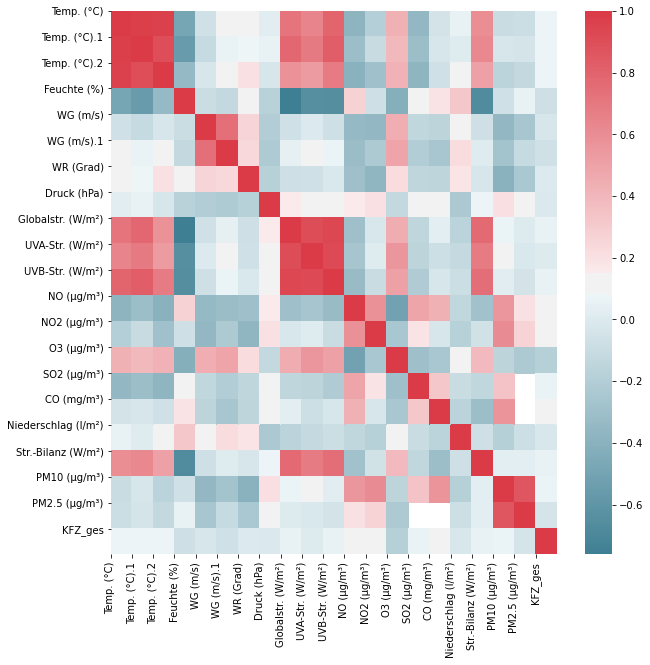

In [199]:
#from utils import heatMap
heatMap(df_ges)

In [200]:
#sns.pairplot(data=df_outer)

In [ ]:
sns.catplot(x='Year',y='Crime Index',kind='box',data=df_ges)

### Descriptive Statistics

### Detection of Missing Values

Deletion of all missing values:

In [ ]:
df_outer=df_outer.dropna()

### Outlier Detection and Handling

### Definition of Sampling Rates

### Features Selection

In [ ]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation

X, y = df_outer.drop(['Crime Index', 'Country', 'Year', 'Safety Index'], axis=1).to_numpy(), df_outer['Crime Index'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_outer.drop(['Crime Index', 'Country', 'Year', 'Safety Index'], axis=1)))

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X, y, discrete_features=discrete, random_state=0)
visualizer.show()

# Modeling

## Data Preparation

### Data Scaling and Normalization

### Split Data into Training and Validation Samples

## Alogrithms Selection

## Baseline Models

## Deep Learning Models

## Hyperparamters Optimization

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.